# Re-Engineering
- I got both too-perfect results and weirdly dis-improving model tuning on my first engineered dataset.
- Because PyCaret automates so much, I want to do two things: compare my engineered data to the original, and in both cases convert the price info into two signals instead of dozens.
    - caution, I had to ditch a version of this file because I used ALL the data and trying to run pandas_profiling was taking 8GB of memory and forcing Chrome to crash the tab
    - the two signals I want to try are "price change between day-before and day-of filing" and "price change between day-of and day-after filing".
- Reading back over previous project files, I am in danger of wandering away from my original question. Although, "my original question" was multifaceted and focused more on relationships than predictions.
    - I would definitely like to see a decision tree and/or other "explainable" prediction method
    - The question I will concentrate on now is, can I use SEC filing data to predict the change in stock price in the days immediately surrounding the filing date?

In [1]:
# redoing my data. I will aim for a "price change" column and I will do two frames, one for change from day before to day of,
# and one for day of to day after
import pandas as pd
import numpy as np

df = pd.read_csv('hf-3-day-prices.csv', parse_dates=['date'])
# most complete revenues data
tech_revenues = ['CSCO', 'FB', 'GOOGL', 'HPQ', 'IBM', 'ORCL']
df_tr = df[df['ticker'].isin(tech_revenues)]
# drop completely null columns
df_tr = df_tr.dropna(axis='columns', how='all')
# drop excess price columns
dropcols = ['split_coefficient', 'split_coef_minus1', 'split_coef_plus1', 'open', 'high', 'low', 'close_adjusted', 
            'volume', 'date_minus1', 'open_minus1', 'high_minus1', 'low_minus1', 'close_adj_minus1', 'volume_minus1', 
            'date_plus1', 'open_plus1', 'high_plus1', 'low_plus1', 'close_adj_plus1', 'volume_plus1']
df_tr.drop(dropcols, axis=1, inplace=True)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [2]:
# where am I missing close prices?
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tr[df_tr['close'].isnull()])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,close,close_minus1,close_plus1
1375,IBM,2012-10-30,2.182470e+09,4.814100e+10,7.085000e+09,NaN,9.411200e+10,1.157780e+11,2.154100e+10,9.38,15000000.0,1.077100e+10,1.000300e+10,NaN,NaN,NaN,2.572000e+09,NaN,563000000.0,NaN,670000000.0,3.513100e+10,NaN,2.458000e+09,2.928500e+10,9.334000e+09,NaN,NaN,NaN,194.53


In [3]:
# for one row, I will just make the close price equal to the "plus1" data point because it's what I have.
# also need to fill in missing plus1 and minus1 prices (set to day-of price)
df_tr['close'].fillna(value=df_tr['close_plus1'], axis=0, inplace=True)
df_tr['close_minus1'].fillna(value=df_tr['close'], axis=0, inplace=True)
df_tr['close_plus1'].fillna(value=df_tr['close'], axis=0, inplace=True)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [4]:
# interpolate in ticker groups. In-place doesn't seem to work. Remember to "apply" instead of "transform" so the ticker column
# does not vanish!
df_interp = df_tr.groupby('ticker').apply(pd.DataFrame.interpolate)
df_interp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  53 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [5]:
# fill everything else with 0 and get ready for pycaret!
df_interp.fillna(0, inplace=True)
# Create two target dataframes: one for minus1 to day-of, one for day-of to plus1
df_minus_dayof = df_interp.copy(deep=True)
df_dayof_plus = df_interp.copy(deep=True)
df_minus_dayof['change'] = df_minus_dayof['close'] - df_minus_dayof['close_minus1']
df_dayof_plus['change'] = df_dayof_plus['close_plus1'] - df_dayof_plus['close']
# calculate percentage as well as scalar change for possible use in a percent-change transformed dataset later
df_minus_dayof['pct_change'] = df_minus_dayof['change'] / df_minus_dayof['close_minus1'] 
df_dayof_plus['pct_change'] = df_dayof_plus['change'] / df_dayof_plus['close']
# drop the actual price columns
dropprice = ['close', 'close_minus1', 'close_plus1']
df_minus_dayof.drop(dropprice, axis=1, inplace=True)
df_dayof_plus.drop(dropprice, axis=1, inplace=True)
# make sure my changes are usually different!
display(df_minus_dayof.iloc[0:5,-2:])
display(df_dayof_plus.iloc[0:5,-2:])

,change,pct_change
713,-0.0900,-0.003736
714,0.0700,0.002917
715,-0.4200,-0.018018
716,-0.1099,-0.005053
717,-0.3600,-0.018405


,change,pct_change
713,-0.32,-0.013333
714,0.21,0.008725
715,0.78,0.034076
716,0.03,0.001386
717,0.26,0.013542


In [6]:
# In order to experiment with different models, also create frames with the percent-change transform
# skip the newly calculated change columns? What will it do to do a percent-change over rows on a column that's already percent
# change from within the row? What the hell, right?
df_m_d_pctchg = pd.DataFrame()
for col in df_minus_dayof.columns:
    if df_minus_dayof[col].dtype == np.float64:
        df_m_d_pctchg[col] = df_minus_dayof.groupby('ticker')[col].pct_change()
    else:
        df_m_d_pctchg[col] = df_minus_dayof[col]
# confident in filling the NaN's here with 0, due to earlier work. I will lose the first row of each ticker.
df_m_d_pctchg.fillna(0, inplace=True)
df_m_d_pctchg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           199 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  199 non-null    float64       
 6   liabilities                       199 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [7]:
df_d_p_pctchg = pd.DataFrame()
for col in df_dayof_plus.columns:
    if df_dayof_plus[col].dtype == np.float64:
        df_d_p_pctchg[col] = df_dayof_plus.groupby('ticker')[col].pct_change()
    else:
        df_d_p_pctchg[col] = df_dayof_plus[col]
# confident in filling the NaN's here with 0, due to earlier work. I will lose the first row of each ticker.
df_d_p_pctchg.fillna(0, inplace=True)
df_d_p_pctchg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           199 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  199 non-null    float64       
 6   liabilities                       199 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

## Outliers! Can PyCaret help me here?
- Earlier I discovered a number of odd data points, in which after the percent-change transform the number was 100 or more, as high as 2700. I decided to "clip" them at (+/-) 100 but I wished I had more information about whether these were likely to be real or data errors. I know it's plausible for a company to be having a stellar good (or bad) result and change its prior numbers by more than 100%, but how big a change is still plausible?
- I'm curious what PyCaret does with outliers!

In [8]:
# let's save this work!
df_minus_dayof.to_csv('minus_dayof_changes.csv')
df_dayof_plus.to_csv('dayof_plus_changes.csv')
df_m_d_pctchg.to_csv('m_d_pctchg.csv')
df_d_p_pctchg.to_csv('d_p_pctchg.csv')

In [9]:
from pycaret.regression import *
print(df_minus_dayof.date.max())
# remember to hold out by date!
training = df_minus_dayof[df_minus_dayof['date']<'2019']
unseen = df_minus_dayof[df_minus_dayof['date']>='2019'] # this holds out ~10% of data for this particular dataset
training.reset_index(drop=True, inplace=True)
unseen.reset_index(drop=True, inplace=True)
# Need to pick one of my two targets...
training.drop('pct_change', axis=1, inplace=True)
unseen.drop('pct_change', axis=1, inplace=True)
print('training: ',training.shape)
print('unseen: ',unseen.shape)
# I will eventually be doing this and following steps... four times!

2019-09-05 00:00:00
training:  (187, 28)
unseen:  (12, 28)


- on non-transformed data, investigate "naive" PyCaret setup vs asking for transform/normalization
- profile may tell me something about the transforms I want, but caution, it takes a LOT of memory
- setting session ID the same in both setup requests will make any randomization identical
- Note the PyCaret workflow seems to be that I'll need to run all the steps on one iteration of "setup"
- I did try profiling and it says LOTS of high correlation, and skewed data all kinds of ways, which I mostly knew.
- And the profile completed but took nearly 3GB of RAM for <200 records. Onward!

In [10]:
exp_naive = setup(data = training, target = 'change', session_id=123, numeric_features=['preferredstockvalue'])
# skipping profile=True to save RAM, it tells me what I already knew

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(130, 48)"


In [11]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.9050,67.7648,5.9584,-0.2642,0.7587,3.8514,0.0170
llar,Lasso Least Angle Regression,2.8614,66.9092,5.9881,-0.3052,0.8367,4.3243,0.6300
knn,K Neighbors Regressor,3.0925,89.2863,6.8112,-0.9927,0.6723,2.6235,0.0260
omp,Orthogonal Matching Pursuit,3.5911,91.7912,7.1238,-1.7845,0.7671,5.2362,0.0060
rf,Random Forest Regressor,3.7736,130.6785,8.2968,-1.8258,0.6516,3.5694,0.0820
par,Passive Aggressive Regressor,4.6169,86.4339,7.0035,-1.9818,1.0803,16.3418,0.0170
catboost,CatBoost Regressor,4.0161,164.2433,9.3505,-2.1380,0.5120,2.5527,1.0630
br,Bayesian Ridge,4.1113,96.3729,7.4144,-2.7016,0.8842,12.2466,0.0330
lr,Linear Regression,4.1113,96.3729,7.4144,-2.7016,0.8842,12.2466,0.7200
et,Extra Trees Regressor,4.0914,148.3020,9.0325,-2.7030,0.5957,3.3818,0.0600


- all of my R-squared vlaues are negative, which my class notes on metrics say means "something is very wrong". More specifically, these models fit worse than "just guess the average".
- Perhaps it's time to do my transformations and see if that works better.

In [12]:
exp_xfrm = setup(data = training, target = 'change', session_id=123, normalize = True, transformation = True, 
                 remove_multicollinearity = True, multicollinearity_threshold = 0.95, numeric_features=['preferredstockvalue']) 

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(130, 44)"


In [13]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,2.8614,66.9092,5.9881,-0.3052,0.8367,4.3243,0.6280
br,Bayesian Ridge,3.0375,81.2965,6.3580,-0.3515,0.7823,5.1322,0.0170
lasso,Lasso Regression,2.8862,72.8207,6.1465,-0.3590,0.8044,3.9559,0.0060
en,Elastic Net,2.8958,74.9547,6.2415,-0.4388,0.7839,3.3498,0.0060
omp,Orthogonal Matching Pursuit,3.5379,89.6932,6.9789,-1.2091,0.7096,5.3642,0.0060
huber,Huber Regressor,3.1813,71.4615,6.2460,-1.4530,0.6897,5.3808,0.0110
rf,Random Forest Regressor,3.7581,130.2929,8.2188,-1.6649,0.6570,3.2727,0.0800
knn,K Neighbors Regressor,3.3032,94.1669,7.1910,-1.8177,0.6526,1.8144,0.0090
catboost,CatBoost Regressor,4.0103,162.3325,9.3273,-2.2431,0.5480,2.6155,0.9180
ada,AdaBoost Regressor,4.6004,214.3343,10.5099,-2.9190,0.8140,9.3681,0.0210


- Transforming changed the order of the "best" models but they all still have negative R-squared. It didn't actually change the LLAR numbers, but the Huber is worse and nothing appears to be "good".
- Let's try the percent-change transformed data.

In [14]:
training = df_m_d_pctchg[df_m_d_pctchg['date']<'2019']
unseen = df_m_d_pctchg[df_m_d_pctchg['date']>='2019'] # this holds out ~10% of data for this particular dataset
training.reset_index(drop=True, inplace=True)
unseen.reset_index(drop=True, inplace=True)
# Need to pick one of my two targets...
training.drop('pct_change', axis=1, inplace=True)
unseen.drop('pct_change', axis=1, inplace=True)
print('training: ',training.shape)
print('unseen: ',unseen.shape)

training:  (187, 28)
unseen:  (12, 28)


In [15]:
exp_naive = setup(data = training, target = 'change', session_id=123, numeric_features=['preferredstockvalue'])

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(119, 50)"


In [16]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,2.2113,19.2695,3.7488,-0.1544,0.6251,1.9971,0.0060
br,Bayesian Ridge,2.2124,19.2746,3.7494,-0.1548,0.6254,2.0007,0.0060
lasso,Lasso Regression,2.2532,19.3923,3.7858,-0.2428,0.6207,2.0648,0.0070
ada,AdaBoost Regressor,2.5586,22.4913,4.1919,-0.5794,0.7858,1.8411,0.0230
catboost,CatBoost Regressor,2.6680,22.9807,4.1841,-0.6360,0.8160,2.2553,0.9240
knn,K Neighbors Regressor,2.6972,22.0424,4.1731,-0.7961,0.7729,2.4415,0.0090
rf,Random Forest Regressor,2.7558,24.0750,4.3680,-0.9471,0.8025,2.2525,0.0750
en,Elastic Net,2.4104,21.1437,4.0689,-1.0604,0.6559,2.1991,0.0060
lightgbm,Light Gradient Boosting Machine,2.8564,25.4496,4.5608,-1.0808,0.8047,1.9381,0.1470
et,Extra Trees Regressor,2.8857,31.8078,4.8633,-1.8576,0.8491,2.6946,0.0560


- Oh boy. This shows the least negative R-squared values so far... Time to bring in the transforms? Even on my once-transformed data?
- Let's also keep in mind going back to clipping the outliers, if this doesn't work so well.

In [17]:
exp_xfrm = setup(data = training, target = 'change', session_id=123, normalize = True, transformation = True, 
                 remove_multicollinearity = True, multicollinearity_threshold = 0.95, numeric_features=['preferredstockvalue']) 

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(119, 50)"


In [18]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.2100,19.2649,3.7484,-0.1539,0.6250,1.9961,0.0050
lasso,Lasso Regression,2.2113,19.2695,3.7488,-0.1544,0.6251,1.9971,0.0060
llar,Lasso Least Angle Regression,2.2113,19.2695,3.7488,-0.1544,0.6251,1.9971,0.0060
en,Elastic Net,2.2093,19.3087,3.7588,-0.1606,0.6296,1.9344,0.0060
knn,K Neighbors Regressor,2.8834,25.6064,4.4434,-0.6673,0.7906,2.3786,0.0080
catboost,CatBoost Regressor,2.6677,23.3623,4.2110,-0.6694,0.8075,2.2854,0.8810
ada,AdaBoost Regressor,2.6464,24.2025,4.3406,-0.7284,0.8239,1.9103,0.0230
omp,Orthogonal Matching Pursuit,2.7340,21.8907,4.2111,-0.8337,0.7585,2.2252,0.0060
rf,Random Forest Regressor,2.7504,24.1633,4.3748,-0.9441,0.8043,2.2434,0.0730
lightgbm,Light Gradient Boosting Machine,2.8153,25.2211,4.5444,-1.0518,0.7664,2.0057,0.1480


- Something other than LLAR on top... still all negative R-squared.
- I think I'm done here. Time to try time series.

### Latest mentor suggestions: 
- test 1, make everything positive, then take log all data points
- test 2, use min-max or similar scaler to scale everything 0-1

In [19]:
# credit: https://stackoverflow.com/questions/66471358/scaling-pandas-column-value-from-0-to-1-in-python
def my_scaler(min_scale_num,max_scale_num,var):
    return (max_scale_num - min_scale_num) * ( (var - min(var)) / (max(var) - min(var)) ) + min_scale_num

In [20]:
# test 1, manual log transform
# credit: https://github.com/tdd-ucd/EPILEPTICSEIZURE_LOG/blob/main/EpilepticSeizure_Modeling_log-PyCaret.ipynb
df_log = pd.DataFrame()
list_of_df  = []

for column in df_minus_dayof:
    if column in ['ticker', 'date']:
            name_of_df = df_minus_dayof[column].reset_index(drop=True)
            list_of_df.append(name_of_df)
    else:
        scale_list = list(my_scaler(1, max(df_minus_dayof[column]), df_minus_dayof[column]))
        my_list = np.log(scale_list)
        name_of_df = pd.DataFrame(my_list, columns=[column], dtype=float)
        list_of_df.append(name_of_df)

df_log = pd.concat(list_of_df, axis=1, ignore_index=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_log.head(10))
    display(df_log.tail(10))

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,pct_change
0,CSCO,2009-11-18,22.472640,24.448990,20.320756,0.0,24.082573,24.957435,24.449473,1.907539,22.635136,22.826688,21.638197,0.0,0.0,0.0,0.0,22.048961,23.502146,0.0,23.157221,22.588873,22.472640,20.055786,20.388870,21.863340,12.409018,3.217924,-0.313880
1,CSCO,2010-02-17,22.478534,24.435936,20.236199,0.0,24.109863,24.949420,24.416835,1.908805,22.643181,22.826688,21.761970,0.0,0.0,0.0,0.0,22.100214,23.502146,0.0,23.157221,22.654518,22.478534,20.055786,20.417738,21.863340,12.409018,3.220927,-0.327165
2,CSCO,2010-05-26,22.467584,24.567868,20.551677,0.0,24.294097,25.100222,24.536308,1.916370,22.683512,22.826688,21.828695,0.0,0.0,0.0,0.0,22.178567,23.502146,0.0,23.157221,22.696279,22.467584,20.055786,20.495902,21.863340,12.409018,3.211703,-0.285942
3,CSCO,2010-09-21,22.455806,24.604035,20.543299,0.0,24.332811,25.123006,24.545758,1.911333,22.653087,22.826688,23.176781,0.0,0.0,0.0,0.0,23.525360,23.502146,0.0,23.157221,22.718404,22.455806,20.055786,21.767815,23.447255,12.409018,3.217550,-0.311271
4,CSCO,2010-11-23,22.441917,24.582116,20.601659,0.0,24.290720,25.109246,24.554502,1.911333,22.652485,22.826688,21.904834,0.0,0.0,0.0,0.0,22.205953,23.502146,0.0,23.131908,22.201879,22.441917,20.055786,20.518208,23.447255,12.409018,3.212837,-0.285196
5,CSCO,2011-02-23,22.433996,24.617718,20.416612,0.0,24.317834,25.133383,24.574902,1.902457,22.602040,22.826688,21.944822,0.0,0.0,0.0,0.0,22.244475,23.502146,0.0,23.208056,22.122286,22.433996,20.055786,20.540027,23.447255,12.409018,3.216043,-0.301098
6,CSCO,2011-05-25,22.428196,24.681740,20.420697,0.0,24.367317,25.173435,24.606224,1.910070,22.637581,22.826688,21.960902,0.0,0.0,0.0,0.0,22.222166,23.502146,0.0,23.200635,22.177968,22.428196,20.055786,20.547196,20.180261,12.409018,3.218112,-0.311539
7,CSCO,2011-09-14,22.416125,24.721018,20.520198,0.0,24.410549,25.193566,22.956203,1.896068,22.564796,22.826688,23.337433,0.0,0.0,0.0,0.0,23.660415,23.502146,0.0,21.641041,22.727491,22.416125,21.821878,21.854563,20.192238,12.409018,3.219239,-0.318877
8,CSCO,2011-11-22,22.404280,24.721702,20.558803,0.0,24.408396,25.192069,24.606730,1.910070,22.633911,22.826688,21.996793,0.0,0.0,0.0,0.0,22.266725,23.502146,0.0,21.636437,21.589951,22.404280,21.821878,20.585729,20.193937,16.300417,3.218112,-0.312475
9,CSCO,2012-02-21,22.405582,24.759543,20.409768,0.0,24.414492,25.217981,24.647559,1.920131,22.682345,22.826688,22.020844,0.0,0.0,0.0,0.0,22.189242,23.502146,0.0,23.251922,20.071665,22.405582,21.821878,20.595986,20.220739,16.300417,3.219614,-0.321318


,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,pct_change
189,ORCL,2017-03-17,0.0,24.847271,19.908512,23.40757,18.851117,25.445493,24.608773,2.040255,23.057950,23.252606,16.213247,23.603419,0.0,0.0,20.281655,13.815459,24.198189,20.427552,22.923632,23.515198,0.0,20.596568,21.476732,22.045022,0.0,3.218300,-0.318264
190,ORCL,2017-06-27,0.0,24.847271,19.908512,23.40757,18.851117,25.445493,24.608773,2.128362,23.327058,23.252606,16.213247,23.916003,0.0,0.0,20.383588,13.815459,23.766164,20.427552,22.923632,23.903472,0.0,20.596568,21.819828,22.045022,0.0,3.217548,-0.317005
191,ORCL,2017-09-18,0.0,25.005012,20.103601,23.40757,18.851117,25.629905,24.733457,1.923878,22.640628,23.166134,16.213247,22.507329,0.0,0.0,19.218188,13.815459,23.472421,20.465358,22.980573,22.462303,0.0,20.596568,20.453670,23.005342,0.0,3.219614,-0.321318
192,ORCL,2017-12-18,0.0,25.005012,20.103601,23.40757,18.851117,25.629905,24.733457,1.984345,22.861627,23.071470,16.213247,23.204164,0.0,0.0,19.953238,13.815459,23.905424,20.501788,22.980573,23.132823,0.0,20.596568,21.102038,23.005342,0.0,3.219614,-0.321318
193,ORCL,2018-03-21,0.0,25.005012,20.103601,23.40757,18.851117,25.629905,24.733457,2.046891,23.059233,22.966898,16.213247,23.624632,0.0,0.0,20.397536,13.815459,24.212428,20.536936,22.980573,23.535149,0.0,20.596568,21.483756,23.005342,0.0,3.219051,-0.320045
194,ORCL,2018-06-22,0.0,25.005012,20.103601,23.40757,18.851117,25.629905,24.733457,2.113003,23.261416,22.966898,16.213247,23.919610,0.0,0.0,20.585153,13.815459,23.725580,20.536936,22.980573,23.848684,0.0,20.596568,21.758641,22.045022,0.0,3.238202,-0.368798
195,ORCL,2018-09-19,0.0,25.028255,19.963652,23.40757,18.851117,25.650799,24.590068,1.933802,22.677899,22.718838,16.213247,22.572508,0.0,0.0,19.468000,13.815459,23.254165,20.581702,22.733510,22.516644,0.0,20.596568,19.039540,22.225341,0.0,3.227091,-0.337758
196,ORCL,2018-12-19,0.0,25.028255,19.963652,23.40757,18.851117,25.650799,24.590068,1.997171,22.908706,22.718838,16.213247,23.280803,0.0,0.0,20.166396,13.815459,23.254165,20.581702,22.733510,23.116097,0.0,20.596568,19.039540,22.225341,0.0,3.230808,-0.347820
197,ORCL,2019-03-18,0.0,25.028255,19.963652,23.40757,18.851117,25.650799,24.590068,1.876654,22.435906,22.718838,16.213247,23.681608,0.0,0.0,20.593157,13.815459,23.254165,20.581702,22.733510,23.116097,0.0,20.596568,19.039540,22.225341,0.0,3.219614,-0.321318
198,ORCL,2019-06-21,0.0,25.028255,19.963652,23.40757,18.851117,25.650799,24.590068,2.132418,23.296830,23.330144,16.213247,23.937290,0.0,0.0,20.723266,13.815459,24.481575,20.581702,22.733510,23.116097,0.0,20.596568,19.039540,21.639557,0.0,3.203157,-0.291265


In [21]:
training = df_log[df_log['date']<'2019']
unseen = df_log[df_log['date']>='2019'] # this holds out ~10% of data for this particular dataset
training.reset_index(drop=True, inplace=True)
unseen.reset_index(drop=True, inplace=True)
# Need to pick one of my two targets...
training.drop('pct_change', axis=1, inplace=True)
unseen.drop('pct_change', axis=1, inplace=True)
print('training: ',training.shape)
print('unseen: ',unseen.shape)

training:  (187, 28)
unseen:  (12, 28)


In [22]:
# will only use naive setup since I've done a manual transform
exp_naive = setup(data = training, target = 'change', session_id=123, numeric_features=['preferredstockvalue'])

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(130, 47)"


In [23]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0980,0.1134,0.2086,-2.1889,0.0706,0.0262,0.0060
knn,K Neighbors Regressor,0.0978,0.1270,0.2297,-2.7486,0.0759,0.0258,0.0090
lasso,Lasso Regression,0.0972,0.1085,0.2051,-2.7856,0.0699,0.0259,0.0060
llar,Lasso Least Angle Regression,0.0972,0.1085,0.2051,-2.7856,0.0699,0.0259,0.0070
en,Elastic Net,0.0975,0.1089,0.2056,-2.7877,0.0700,0.0260,0.0060
ada,AdaBoost Regressor,0.1114,0.2179,0.2977,-3.7063,0.1101,0.0297,0.0190
catboost,CatBoost Regressor,0.1104,0.1685,0.2760,-4.6068,0.0905,0.0295,0.9860
lightgbm,Light Gradient Boosting Machine,0.1111,0.1251,0.2343,-5.4887,0.0768,0.0299,0.0230
huber,Huber Regressor,0.0945,0.1121,0.2196,-6.8238,0.0739,0.0255,0.0130
rf,Random Forest Regressor,0.1183,0.1751,0.2857,-8.0105,0.0922,0.0316,0.0850


- Nope! I did pick "scale from 1 to column max" a little arbitrarily. What happens if I scale everything to the same range before taking log transform? Is that any different from using a min-max scaler?

In [24]:
df_log2 = pd.DataFrame()
list_of_df  = []

for column in df_minus_dayof:
    if column in ['ticker', 'date']:
            name_of_df = df_minus_dayof[column].reset_index(drop=True)
            list_of_df.append(name_of_df)
    else:
        scale_list = list(my_scaler(1, 100, df_minus_dayof[column]))
        my_list = np.log(scale_list)
        name_of_df = pd.DataFrame(my_list, columns=[column], dtype=float)
        list_of_df.append(name_of_df)

df_log2 = pd.concat(list_of_df, axis=1, ignore_index=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_log2.head(10))
    display(df_log2.tail(10))

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,pct_change
0,CSCO,2009-11-18,4.599335,3.443064,1.638729,0.0,3.254779,3.412653,3.449191,2.649010,3.126421,3.909159,1.518291,0.0,0.0,0.0,0.0,3.030564,2.702371,0.0,4.484743,2.617310,4.599335,2.169616,1.007722,3.059264,0.039181,3.959541,3.660674
1,CSCO,2010-02-17,4.605170,3.430429,1.571164,0.0,3.281030,3.404902,3.417607,2.650392,3.134115,3.909159,1.616226,0.0,0.0,0.0,0.0,3.079402,2.702371,0.0,4.484743,2.678307,4.605170,2.169616,1.026148,3.059264,0.039181,3.962609,3.694950
2,CSCO,2010-05-26,4.594330,3.558351,1.828776,0.0,3.458919,3.551045,3.533381,2.658644,3.172724,3.909159,1.670047,0.0,0.0,0.0,0.0,3.154283,2.702371,0.0,4.484743,2.717254,4.594330,2.169616,1.076997,3.059264,0.039181,3.953184,3.582862
3,CSCO,2010-09-21,4.582672,3.593506,1.821748,0.0,3.496437,3.573183,3.542556,2.653150,3.143591,3.909159,2.868070,0.0,0.0,0.0,0.0,4.468996,2.702371,0.0,4.484743,2.737933,4.582672,2.169616,2.067681,4.605170,0.039181,3.959159,3.653747
4,CSCO,2010-11-23,4.568926,3.572197,1.870897,0.0,3.455648,3.559812,3.551047,2.653150,3.143016,3.909159,1.732290,0.0,0.0,0.0,0.0,3.180516,2.702371,0.0,4.459720,2.264230,4.568926,2.169616,1.091760,4.605170,0.039181,3.954343,3.580667
5,CSCO,2011-02-23,4.561087,3.606816,1.716672,0.0,3.481917,3.583269,3.570868,2.643463,3.094801,3.909159,1.765319,0.0,0.0,0.0,0.0,3.217466,2.702371,0.0,4.535019,2.193209,4.561087,2.169616,1.106309,4.605170,0.039181,3.957619,3.626093
6,CSCO,2011-05-25,4.555348,3.669153,1.720024,0.0,3.529915,3.622230,3.601322,2.651772,3.128759,3.909159,1.778666,0.0,0.0,0.0,0.0,3.196060,2.702371,0.0,4.527678,2.242831,4.555348,2.169616,1.111112,1.563177,0.039181,3.959734,3.654464
7,CSCO,2011-09-14,4.543405,3.707449,1.802420,0.0,3.571906,3.641829,2.059977,2.636486,3.059274,3.909159,3.020255,0.0,0.0,0.0,0.0,4.602602,2.702371,0.0,3.007878,2.746435,4.543405,3.836231,2.143864,1.572657,0.039181,3.960885,3.673759
8,CSCO,2011-11-22,4.531686,3.708116,1.834761,0.0,3.569814,3.640371,3.601814,2.651772,3.125251,3.909159,1.808586,0.0,0.0,0.0,0.0,3.238834,2.702371,0.0,3.003502,1.736366,4.531686,3.836231,1.137124,1.574003,1.084232,3.959734,3.656953
9,CSCO,2012-02-21,4.532975,3.745045,1.711060,0.0,3.575739,3.665611,3.641552,2.662744,3.171606,3.909159,1.828735,0.0,0.0,0.0,0.0,3.164505,2.702371,0.0,4.578424,0.705372,4.532975,3.836231,1.144103,1.595311,1.084232,3.961268,3.680067


,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,pct_change
189,ORCL,2017-03-17,0.0,3.830787,1.320971,4.60517,0.125031,3.887903,3.603802,2.793006,3.533992,4.328097,0.01558,2.772782,0.0,0.0,2.883220,0.005221,3.364215,4.452685,4.254118,3.498543,0.0,2.661511,1.818444,3.233119,0.0,3.959925,3.672167
190,ORCL,2017-06-27,0.0,3.830787,1.320971,4.60517,0.125031,3.887903,3.603802,2.887757,3.796190,4.328097,0.01558,3.068449,0.0,0.0,2.979715,0.005221,2.950709,4.452685,4.254118,3.877038,0.0,2.661511,2.113263,3.233119,0.0,3.959157,3.668886
191,ORCL,2017-09-18,0.0,3.985357,1.467604,4.60517,0.125031,4.068858,3.725290,2.666828,3.131673,4.242815,0.01558,1.794034,0.0,0.0,1.920603,0.005221,2.674667,4.490059,4.310273,2.500542,0.0,2.661511,1.049350,4.168799,0.0,3.961268,3.680067
192,ORCL,2017-12-18,0.0,3.985357,1.467604,4.60517,0.125031,4.068858,3.725290,2.732542,3.343981,4.149577,0.01558,2.403730,0.0,0.0,2.576322,0.005221,3.083147,4.526087,4.310273,3.130155,0.0,2.661511,1.514920,4.168799,0.0,3.961268,3.680067
193,ORCL,2018-03-21,0.0,3.985357,1.467604,4.60517,0.125031,4.068858,3.725290,2.800165,3.535237,4.046742,0.01558,2.792683,0.0,0.0,2.992959,0.005221,3.377966,4.560862,4.310273,3.517897,0.0,2.661511,1.824332,4.168799,0.0,3.960693,3.676784
194,ORCL,2018-06-22,0.0,3.985357,1.467604,4.60517,0.125031,4.068858,3.725290,2.871285,3.732070,4.046742,0.01558,3.071888,0.0,0.0,3.171961,0.005221,2.912289,4.560862,4.310273,3.823416,0.0,2.661511,2.059672,3.233119,0.0,3.980258,3.792753
195,ORCL,2018-09-19,0.0,4.008173,1.361691,4.60517,0.125031,4.089399,3.585611,2.677636,3.167347,3.803591,0.01558,1.848664,0.0,0.0,2.137490,0.005221,2.473083,4.605170,4.066966,2.550534,0.0,2.661511,0.372400,3.406911,0.0,3.968907,3.721153
196,ORCL,2018-12-19,0.0,4.008173,1.361691,4.60517,0.125031,4.089399,3.585611,2.746437,3.389435,3.803591,0.01558,2.473679,0.0,0.0,2.774773,0.005221,2.473083,4.605170,4.066966,3.114166,0.0,2.661511,0.372400,3.406911,0.0,3.972705,3.745176
197,ORCL,2019-03-18,0.0,4.008173,1.361691,4.60517,0.125031,4.089399,3.585611,2.615258,2.936817,3.803591,0.01558,2.846260,0.0,0.0,3.179632,0.005221,2.473083,4.605170,4.066966,3.114166,0.0,2.661511,0.372400,3.406911,0.0,3.961268,3.680067
198,ORCL,2019-06-21,0.0,4.008173,1.361691,4.60517,0.125031,4.089399,3.585611,2.892104,3.766651,4.404650,0.01558,3.088756,0.0,0.0,3.304652,0.005221,3.639030,4.605170,4.066966,3.114166,0.0,2.661511,0.372400,2.847180,0.0,3.944449,3.598335


In [25]:
training = df_log2[df_log2['date']<'2019']
unseen = df_log2[df_log2['date']>='2019'] # this holds out ~10% of data for this particular dataset
training.reset_index(drop=True, inplace=True)
unseen.reset_index(drop=True, inplace=True)
# Need to pick one of my two targets...
training.drop('pct_change', axis=1, inplace=True)
unseen.drop('pct_change', axis=1, inplace=True)
print('training: ',training.shape)
print('unseen: ',unseen.shape)

training:  (187, 28)
unseen:  (12, 28)


In [26]:
exp_naive = setup(data = training, target = 'change', session_id=123, numeric_features=['preferredstockvalue'])

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(130, 46)"


In [27]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.1112,0.1597,0.2395,-2.7245,0.0724,0.0225,0.0070
knn,K Neighbors Regressor,0.1100,0.1776,0.2628,-2.7871,0.0775,0.0221,0.0090
lasso,Lasso Regression,0.1096,0.1520,0.2328,-3.5810,0.0711,0.0222,0.0070
en,Elastic Net,0.1096,0.1520,0.2328,-3.5810,0.0711,0.0222,0.0060
llar,Lasso Least Angle Regression,0.1096,0.1520,0.2328,-3.5810,0.0711,0.0222,0.0070
catboost,CatBoost Regressor,0.1272,0.2390,0.3224,-5.2293,0.0938,0.0263,0.9990
ada,AdaBoost Regressor,0.1107,0.2148,0.2919,-5.4470,0.0845,0.0222,0.0210
lightgbm,Light Gradient Boosting Machine,0.1233,0.1725,0.2633,-6.1504,0.0773,0.0254,0.0230
et,Extra Trees Regressor,0.1090,0.1702,0.2608,-7.6084,0.0767,0.0223,0.0640
xgboost,Extreme Gradient Boosting,0.1607,0.3229,0.3952,-11.2407,0.1159,0.0348,0.1050


- Still nope! One more try, with scale down to 0-1 (ie min-max scaler) and... no log transform, I think

In [28]:
df_mmx = pd.DataFrame()
list_of_df  = []

for column in df_minus_dayof:
    if column in ['ticker', 'date']:
            name_of_df = df_minus_dayof[column].reset_index(drop=True)
            list_of_df.append(name_of_df)
    else:
        scale_list = list(my_scaler(0, 1, df_minus_dayof[column]))
        #my_list = np.log(scale_list)
        name_of_df = pd.DataFrame(scale_list, columns=[column], dtype=float)
        list_of_df.append(name_of_df)

df_mmx = pd.concat(list_of_df, axis=1, ignore_index=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_mmx.head(10))
    display(df_mmx.tail(10))

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,pct_change
0,CSCO,2009-11-18,0.994123,0.305885,0.041905,0.0,0.251655,0.296421,0.307828,0.132728,0.220124,0.493505,0.036004,0.0,0.0,0.0,0.0,0.199080,0.140556,0.0,0.885395,0.128271,0.994123,0.078333,0.017569,0.205170,0.000404,0.519528,0.382702
1,CSCO,2010-02-17,1.000000,0.301918,0.038508,0.0,0.258618,0.294054,0.297943,0.132925,0.221902,0.493505,0.040748,0.0,0.0,0.0,0.0,0.209549,0.140556,0.0,0.885395,0.136974,1.000000,0.078333,0.018084,0.205170,0.000404,0.521155,0.396400
2,CSCO,2010-05-26,0.989110,0.344498,0.052791,0.0,0.310935,0.341916,0.335753,0.134110,0.231034,0.493505,0.043560,0.0,0.0,0.0,0.0,0.226629,0.140556,0.0,0.885395,0.142815,0.989110,0.078333,0.019554,0.205170,0.000404,0.516172,0.353296
3,CSCO,2010-09-21,0.977528,0.357185,0.052350,0.0,0.323209,0.349796,0.338941,0.133320,0.224111,0.493505,0.167707,0.0,0.0,0.0,0.0,0.871404,0.140556,0.0,0.885395,0.146010,0.977528,0.078333,0.069762,1.000000,0.000404,0.519326,0.379991
4,CSCO,2010-11-23,0.964045,0.349442,0.055496,0.0,0.309887,0.345016,0.341917,0.133320,0.223976,0.493505,0.047006,0.0,0.0,0.0,0.0,0.232921,0.140556,0.0,0.863265,0.087108,0.964045,0.078333,0.019995,1.000000,0.000404,0.516782,0.352500
5,CSCO,2011-02-23,0.956439,0.362106,0.046121,0.0,0.318404,0.353445,0.348964,0.131938,0.212958,0.493505,0.048924,0.0,0.0,0.0,0.0,0.242069,0.140556,0.0,0.931569,0.080444,0.956439,0.078333,0.020436,1.000000,0.000404,0.518511,0.369351
6,CSCO,2011-05-25,0.950908,0.386047,0.046310,0.0,0.334556,0.367888,0.360067,0.133123,0.220663,0.493505,0.049717,0.0,0.0,0.0,0.0,0.236728,0.140556,0.0,0.924681,0.085050,0.950908,0.078333,0.020583,0.038121,0.000404,0.519630,0.380271
7,CSCO,2011-09-14,0.939499,0.401512,0.051155,0.0,0.349337,0.375369,0.069149,0.130950,0.205172,0.493505,0.196935,0.0,0.0,0.0,0.0,0.997409,0.140556,0.0,0.194388,0.147343,0.939499,0.458085,0.076084,0.038580,0.000404,0.520240,0.387876
8,CSCO,2011-11-22,0.928436,0.401787,0.053168,0.0,0.348586,0.374808,0.360249,0.133123,0.219855,0.493505,0.051533,0.0,0.0,0.0,0.0,0.247515,0.140556,0.0,0.193495,0.047239,0.928436,0.458085,0.021392,0.038646,0.019769,0.519630,0.381244
9,CSCO,2012-02-21,0.929646,0.417282,0.045806,0.0,0.350717,0.384647,0.375263,0.134703,0.230765,0.493505,0.052788,0.0,0.0,0.0,0.0,0.229061,0.140556,0.0,0.973342,0.010349,0.929646,0.458085,0.021612,0.039696,0.019769,0.520443,0.390394


,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,pct_change
189,ORCL,2017-03-17,0.0,0.455544,0.027748,1.0,0.001345,0.482913,0.360986,0.154849,0.335964,0.755555,0.000159,0.151546,0.0,0.0,0.170421,0.000053,0.281927,0.857143,0.700957,0.323912,0.0,0.134524,0.052144,0.246047,0.0,0.519731,0.387243
190,ORCL,2017-06-27,0.0,0.455544,0.027748,1.0,0.001345,0.482913,0.360986,0.171242,0.439709,0.755555,0.000159,0.207157,0.0,0.0,0.188709,0.000053,0.183025,0.857143,0.700957,0.477586,0.0,0.134524,0.073487,0.246047,0.0,0.519325,0.385941
191,ORCL,2017-09-18,0.0,0.533379,0.033726,1.0,0.001345,0.580709,0.408922,0.135295,0.221336,0.692965,0.000159,0.050643,0.0,0.0,0.058839,0.000053,0.136440,0.890169,0.742028,0.113021,0.0,0.134524,0.018745,0.642806,0.0,0.520443,0.390394
192,ORCL,2017-12-18,0.0,0.533379,0.033726,1.0,0.001345,0.580709,0.408922,0.145171,0.276078,0.630375,0.000159,0.101660,0.0,0.0,0.122714,0.000053,0.210374,0.923195,0.742028,0.220985,0.0,0.134524,0.035849,0.642806,0.0,0.520443,0.390394
193,ORCL,2018-03-21,0.0,0.533379,0.033726,1.0,0.001345,0.580709,0.408922,0.156034,0.336395,0.567786,0.000159,0.154796,0.0,0.0,0.191360,0.000053,0.285970,0.956221,0.742028,0.330439,0.0,0.134524,0.052512,0.642806,0.0,0.520138,0.389082
194,ORCL,2018-06-22,0.0,0.533379,0.033726,1.0,0.001345,0.580709,0.408922,0.168280,0.411773,0.567786,0.000159,0.207905,0.0,0.0,0.230851,0.000053,0.175746,0.956221,0.742028,0.452124,0.0,0.134524,0.069125,0.246047,0.0,0.530614,0.438166
195,ORCL,2018-09-19,0.0,0.545921,0.029321,1.0,0.001345,0.592970,0.354297,0.136875,0.229741,0.443051,0.000159,0.054054,0.0,0.0,0.075537,0.000053,0.109686,1.000000,0.579592,0.119333,0.0,0.134524,0.004558,0.294666,0.0,0.524512,0.407192
196,ORCL,2018-12-19,0.0,0.545921,0.029321,1.0,0.001345,0.592970,0.354297,0.147343,0.289386,0.443051,0.000159,0.109758,0.0,0.0,0.151869,0.000053,0.109686,1.000000,0.579592,0.217320,0.0,0.134524,0.004558,0.294666,0.0,0.526546,0.417338
197,ORCL,2019-03-18,0.0,0.545921,0.029321,1.0,0.001345,0.592970,0.354297,0.127987,0.180361,0.443051,0.000159,0.163871,0.0,0.0,0.232706,0.000053,0.109686,1.000000,0.579592,0.217320,0.0,0.134524,0.004558,0.294666,0.0,0.520443,0.390394
198,ORCL,2019-06-21,0.0,0.545921,0.029321,1.0,0.001345,0.592970,0.354297,0.172032,0.426616,0.816470,0.000159,0.211614,0.0,0.0,0.265041,0.000053,0.374292,1.000000,0.579592,0.217320,0.0,0.134524,0.004558,0.164031,0.0,0.511595,0.358963


In [29]:
training = df_mmx[df_mmx['date']<'2019']
unseen = df_mmx[df_mmx['date']>='2019'] # this holds out ~10% of data for this particular dataset
training.reset_index(drop=True, inplace=True)
unseen.reset_index(drop=True, inplace=True)
# Need to pick one of my two targets...
training.drop('pct_change', axis=1, inplace=True)
unseen.drop('pct_change', axis=1, inplace=True)
print('training: ',training.shape)
print('unseen: ',unseen.shape)

training:  (187, 28)
unseen:  (12, 28)


In [30]:
exp_naive = setup(data = training, target = 'change', session_id=123, numeric_features=['preferredstockvalue'])

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 28)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(130, 48)"


In [31]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0291,0.0069,0.0609,-0.3052,0.0427,0.0771,0.0060
en,Elastic Net,0.0291,0.0069,0.0609,-0.3052,0.0427,0.0771,0.0070
llar,Lasso Least Angle Regression,0.0291,0.0069,0.0609,-0.3052,0.0427,0.0771,0.0060
br,Bayesian Ridge,0.0307,0.0083,0.0644,-0.3467,0.0449,0.0807,0.0060
knn,K Neighbors Regressor,0.0335,0.0095,0.0719,-1.2365,0.0500,0.0861,0.0090
rf,Random Forest Regressor,0.0378,0.0136,0.0835,-1.4744,0.0578,0.0924,0.0870
huber,Huber Regressor,0.0334,0.0076,0.0661,-1.7531,0.0459,0.0853,0.0130
omp,Orthogonal Matching Pursuit,0.0365,0.0095,0.0725,-1.7845,0.0503,0.0942,0.0060
ridge,Ridge Regression,0.0383,0.0099,0.0746,-2.1561,0.0517,0.0944,0.0060
catboost,CatBoost Regressor,0.0414,0.0169,0.0953,-2.2885,0.0653,0.1000,1.1950


- This might be the closest I've gotten, but it's still all negative R2.
- Next mentor conversation: I think I should at least be applying transforms in ticker groups, so that I'm scaling each stock with respect to itself rather than scaling across a group of different stocks. Also I still want to test whether I should be applying time series corrections.

### Real next mentor conversation:
- This last model with everything scaled 0-1 is actually not terrible. MAE and RMSE quite small for the top models, and even the negative R2 is small.
- Let's look at dropping the categorical and date columns, and asking PyCaret to remove outliers, and call it good enough.

In [32]:
training.drop(['ticker','date'], axis=1, inplace=True)
unseen.drop(['ticker','date'], axis=1, inplace=True)
exp_outliers = setup(data = training, target = 'change', session_id=123, numeric_features=['preferredstockvalue'],
                     remove_outliers=True)

,Description,Value
0,session_id,123
1,Target,change
2,Original Data,"(187, 26)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(123, 25)"


In [33]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0276,0.0069,0.0601,-0.2390,0.0422,0.0722,0.0070
en,Elastic Net,0.0276,0.0069,0.0601,-0.2390,0.0422,0.0722,0.0070
llar,Lasso Least Angle Regression,0.0276,0.0069,0.0601,-0.2390,0.0422,0.0722,0.0070
br,Bayesian Ridge,0.0288,0.0081,0.0633,-0.2812,0.0443,0.0760,0.0060
huber,Huber Regressor,0.0276,0.0068,0.0605,-0.4427,0.0425,0.0724,0.0130
omp,Orthogonal Matching Pursuit,0.0319,0.0084,0.0649,-0.5896,0.0453,0.0822,0.0060
ridge,Ridge Regression,0.0332,0.0089,0.0682,-1.0521,0.0475,0.0836,0.0070
knn,K Neighbors Regressor,0.0315,0.0094,0.0700,-1.2443,0.0489,0.0806,0.0100
rf,Random Forest Regressor,0.0375,0.0149,0.0849,-1.7685,0.0589,0.0848,0.0770
catboost,CatBoost Regressor,0.0396,0.0189,0.0922,-1.8372,0.0641,0.0879,0.8840


- A minimal improvement. Let's move on. Finish the PyCaret processing (create, tune, run on unseen) with the top 3 models here.

In [35]:
lso = create_model('lasso')
ent = create_model('en')
lla = create_model('llar')
tuned_lso = tune_model(lso)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0197,0.0019,0.0440,-0.1098,0.0278,0.0333
1,0.0178,0.0008,0.0278,-0.0477,0.0182,0.0337
2,0.0852,0.0320,0.1790,-0.0000,0.1189,0.3868
3,0.0061,0.0001,0.0079,-0.4796,0.0052,0.0116
4,0.0265,0.0024,0.0489,-0.0361,0.0311,0.0471
5,0.0150,0.0005,0.0234,-0.5952,0.0152,0.0273
6,0.0363,0.0077,0.0876,-0.0725,0.0638,0.1331
7,0.0071,0.0001,0.0119,-0.4100,0.0078,0.0133
8,0.0472,0.0227,0.1506,-0.1018,0.1212,0.0079
9,0.0150,0.0004,0.0198,-0.5378,0.0129,0.0278


In [36]:
tuned_ent = tune_model(ent)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0197,0.0019,0.0440,-0.1098,0.0278,0.0333
1,0.0178,0.0008,0.0278,-0.0477,0.0182,0.0337
2,0.0852,0.0320,0.1790,-0.0000,0.1189,0.3868
3,0.0061,0.0001,0.0079,-0.4796,0.0052,0.0116
4,0.0265,0.0024,0.0489,-0.0361,0.0311,0.0471
5,0.0150,0.0005,0.0234,-0.5952,0.0152,0.0273
6,0.0363,0.0077,0.0876,-0.0725,0.0638,0.1331
7,0.0071,0.0001,0.0119,-0.4100,0.0078,0.0133
8,0.0472,0.0227,0.1506,-0.1018,0.1212,0.0079
9,0.0150,0.0004,0.0198,-0.5378,0.0129,0.0278


In [37]:
tuned_lla = tune_model(lla)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0197,0.0019,0.0440,-0.1098,0.0278,0.0333
1,0.0178,0.0008,0.0278,-0.0477,0.0182,0.0337
2,0.0852,0.0320,0.1790,-0.0000,0.1189,0.3868
3,0.0061,0.0001,0.0079,-0.4796,0.0052,0.0116
4,0.0265,0.0024,0.0489,-0.0361,0.0311,0.0471
5,0.0150,0.0005,0.0234,-0.5952,0.0152,0.0273
6,0.0363,0.0077,0.0876,-0.0725,0.0638,0.1331
7,0.0071,0.0001,0.0119,-0.4100,0.0078,0.0133
8,0.0472,0.0227,0.1506,-0.1018,0.1212,0.0079
9,0.0150,0.0004,0.0198,-0.5378,0.0129,0.0278


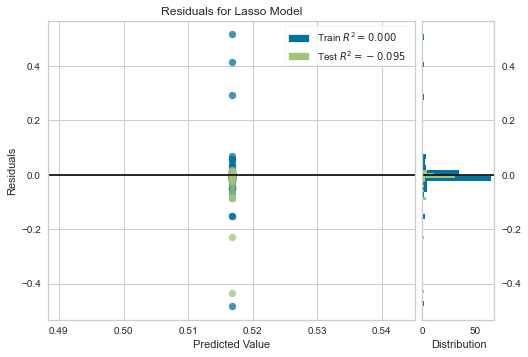

In [38]:
plot_model(tuned_lso)

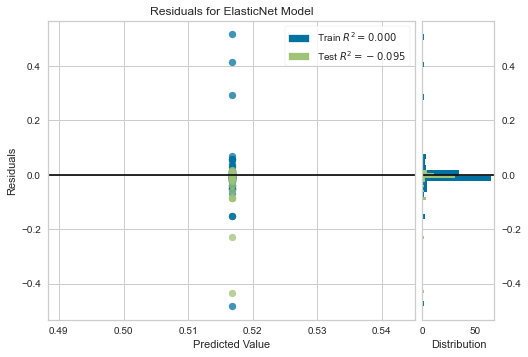

In [39]:
plot_model(tuned_ent)

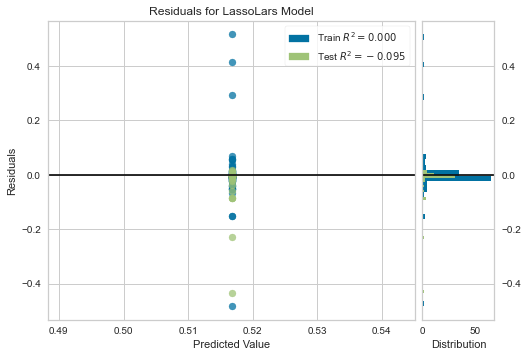

In [40]:
plot_model(tuned_lla)

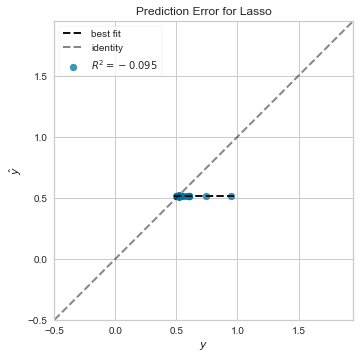

In [41]:
plot_model(tuned_lso, plot='error')

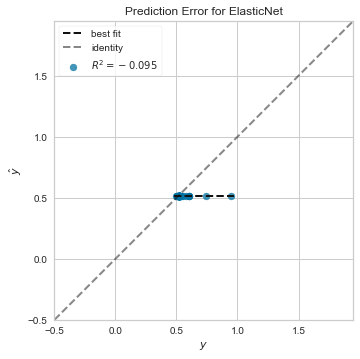

In [42]:
plot_model(tuned_ent, plot='error')

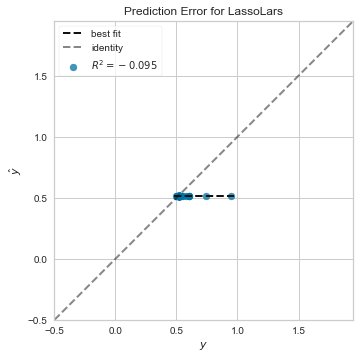

In [43]:
plot_model(tuned_lla, plot='error')

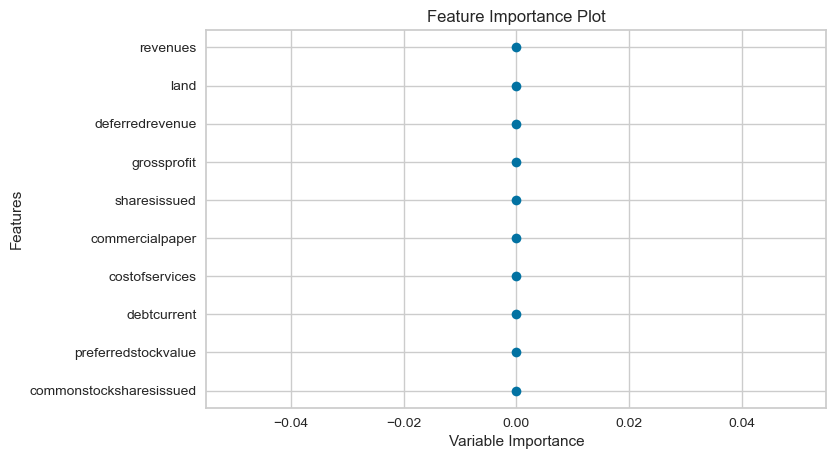

In [44]:
plot_model(tuned_lso, plot='feature')

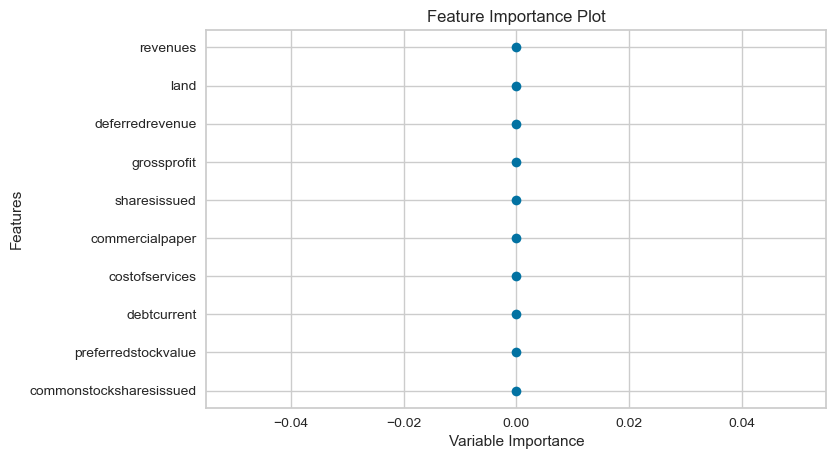

In [45]:
plot_model(tuned_ent, plot='feature')

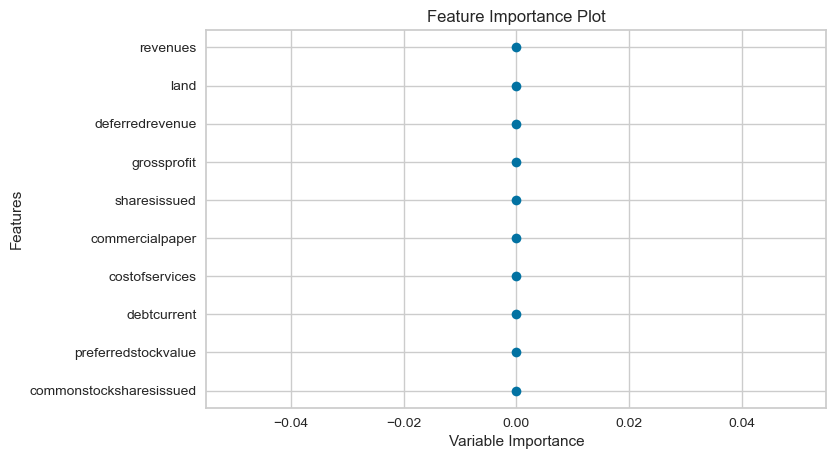

In [46]:
plot_model(tuned_lla, plot='feature')

- The feature importances make me suspicious. Actually all the plots look almost exactly the same, but how are all the feature importances zero? Does regression not create importance numbers?

In [47]:
predict_model(tuned_lso)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.0222,0.0047,0.0686,-0.0949,0.0408,0.0323


,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,...,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,Label
0,0.384545,0.280983,0.327691,0.000000,0.861340,0.497601,0.140101,0.185661,0.172387,0.432522,...,0.000000,0.212245,0.189525,0.000000,0.172676,0.207988,0.054393,0.000000,0.523596,0.51674
1,0.384458,0.296936,0.341094,0.000000,0.893836,0.508105,0.130785,0.178353,0.172387,0.432283,...,0.000000,0.212691,0.203030,0.000000,0.132147,0.214678,0.054262,0.000000,0.515053,0.51674
2,0.380985,0.378265,0.899893,0.000000,0.001345,0.535744,0.311088,0.201264,0.408001,0.432761,...,0.000000,0.178571,0.012858,0.000000,0.000000,0.492477,0.027098,0.000000,0.517290,0.51674
3,0.964045,0.349442,0.055496,0.000000,0.309887,0.345016,0.341917,0.133320,0.223976,0.493505,...,0.000000,0.863265,0.087108,0.964045,0.078333,0.019995,1.000000,0.000404,0.516782,0.51674
4,0.379872,0.342018,0.496382,0.000000,0.876907,0.513065,0.153596,0.388307,0.172387,0.974397,...,0.000000,0.215497,0.995629,0.000000,0.375324,1.000000,0.602388,0.000000,0.518206,0.51674
5,0.000000,0.270226,0.023595,1.000000,0.001345,0.337779,0.334717,0.165910,0.440867,0.645382,...,0.797235,0.646110,0.217320,0.000000,0.134524,0.093433,0.193557,0.000000,0.522579,0.51674
6,0.000000,0.441864,0.021834,1.000000,0.001345,0.477439,0.350635,0.137863,0.229687,0.772134,...,0.857143,0.665689,0.217320,0.000000,0.134524,0.017814,0.131159,0.000000,0.529292,0.51674
7,0.373691,0.311043,0.442333,0.000000,0.768166,0.474245,0.178626,0.296465,0.172387,0.786730,...,0.000000,0.220982,0.707058,0.000000,0.375324,0.750772,0.398333,0.000000,0.501221,0.51674
8,0.020225,0.000000,0.000000,0.000000,0.013855,0.029119,0.051751,0.125025,0.171148,0.432420,...,0.000000,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.505797,0.51674
9,0.000000,0.455544,0.027748,1.000000,0.001345,0.482913,0.360986,0.144776,0.278260,0.755555,...,0.857143,0.700957,0.217320,0.000000,0.134524,0.036045,0.246047,0.000000,0.520443,0.51674


To avoid lots of scrolling, mean numbers from tuned model: Mean	0.0276	0.0069	0.0601	-0.2390	0.0422	0.0722
- pretty close, I think

In [48]:
predict_model(tuned_ent)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.0222,0.0047,0.0686,-0.0949,0.0408,0.0323


,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,...,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,Label
0,0.384545,0.280983,0.327691,0.000000,0.861340,0.497601,0.140101,0.185661,0.172387,0.432522,...,0.000000,0.212245,0.189525,0.000000,0.172676,0.207988,0.054393,0.000000,0.523596,0.51674
1,0.384458,0.296936,0.341094,0.000000,0.893836,0.508105,0.130785,0.178353,0.172387,0.432283,...,0.000000,0.212691,0.203030,0.000000,0.132147,0.214678,0.054262,0.000000,0.515053,0.51674
2,0.380985,0.378265,0.899893,0.000000,0.001345,0.535744,0.311088,0.201264,0.408001,0.432761,...,0.000000,0.178571,0.012858,0.000000,0.000000,0.492477,0.027098,0.000000,0.517290,0.51674
3,0.964045,0.349442,0.055496,0.000000,0.309887,0.345016,0.341917,0.133320,0.223976,0.493505,...,0.000000,0.863265,0.087108,0.964045,0.078333,0.019995,1.000000,0.000404,0.516782,0.51674
4,0.379872,0.342018,0.496382,0.000000,0.876907,0.513065,0.153596,0.388307,0.172387,0.974397,...,0.000000,0.215497,0.995629,0.000000,0.375324,1.000000,0.602388,0.000000,0.518206,0.51674
5,0.000000,0.270226,0.023595,1.000000,0.001345,0.337779,0.334717,0.165910,0.440867,0.645382,...,0.797235,0.646110,0.217320,0.000000,0.134524,0.093433,0.193557,0.000000,0.522579,0.51674
6,0.000000,0.441864,0.021834,1.000000,0.001345,0.477439,0.350635,0.137863,0.229687,0.772134,...,0.857143,0.665689,0.217320,0.000000,0.134524,0.017814,0.131159,0.000000,0.529292,0.51674
7,0.373691,0.311043,0.442333,0.000000,0.768166,0.474245,0.178626,0.296465,0.172387,0.786730,...,0.000000,0.220982,0.707058,0.000000,0.375324,0.750772,0.398333,0.000000,0.501221,0.51674
8,0.020225,0.000000,0.000000,0.000000,0.013855,0.029119,0.051751,0.125025,0.171148,0.432420,...,0.000000,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.505797,0.51674
9,0.000000,0.455544,0.027748,1.000000,0.001345,0.482913,0.360986,0.144776,0.278260,0.755555,...,0.857143,0.700957,0.217320,0.000000,0.134524,0.036045,0.246047,0.000000,0.520443,0.51674


To avoid lots of scrolling, mean numbers from tuned model: Mean	0.0276	0.0069	0.0601	-0.2390	0.0422	0.0722
- basically exactly the same, both tuned and predicted

In [49]:
predict_model(tuned_lla)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,0.0222,0.0047,0.0686,-0.0949,0.0408,0.0323


,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,...,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,Label
0,0.384545,0.280983,0.327691,0.000000,0.861340,0.497601,0.140101,0.185661,0.172387,0.432522,...,0.000000,0.212245,0.189525,0.000000,0.172676,0.207988,0.054393,0.000000,0.523596,0.51674
1,0.384458,0.296936,0.341094,0.000000,0.893836,0.508105,0.130785,0.178353,0.172387,0.432283,...,0.000000,0.212691,0.203030,0.000000,0.132147,0.214678,0.054262,0.000000,0.515053,0.51674
2,0.380985,0.378265,0.899893,0.000000,0.001345,0.535744,0.311088,0.201264,0.408001,0.432761,...,0.000000,0.178571,0.012858,0.000000,0.000000,0.492477,0.027098,0.000000,0.517290,0.51674
3,0.964045,0.349442,0.055496,0.000000,0.309887,0.345016,0.341917,0.133320,0.223976,0.493505,...,0.000000,0.863265,0.087108,0.964045,0.078333,0.019995,1.000000,0.000404,0.516782,0.51674
4,0.379872,0.342018,0.496382,0.000000,0.876907,0.513065,0.153596,0.388307,0.172387,0.974397,...,0.000000,0.215497,0.995629,0.000000,0.375324,1.000000,0.602388,0.000000,0.518206,0.51674
5,0.000000,0.270226,0.023595,1.000000,0.001345,0.337779,0.334717,0.165910,0.440867,0.645382,...,0.797235,0.646110,0.217320,0.000000,0.134524,0.093433,0.193557,0.000000,0.522579,0.51674
6,0.000000,0.441864,0.021834,1.000000,0.001345,0.477439,0.350635,0.137863,0.229687,0.772134,...,0.857143,0.665689,0.217320,0.000000,0.134524,0.017814,0.131159,0.000000,0.529292,0.51674
7,0.373691,0.311043,0.442333,0.000000,0.768166,0.474245,0.178626,0.296465,0.172387,0.786730,...,0.000000,0.220982,0.707058,0.000000,0.375324,0.750772,0.398333,0.000000,0.501221,0.51674
8,0.020225,0.000000,0.000000,0.000000,0.013855,0.029119,0.051751,0.125025,0.171148,0.432420,...,0.000000,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.505797,0.51674
9,0.000000,0.455544,0.027748,1.000000,0.001345,0.482913,0.360986,0.144776,0.278260,0.755555,...,0.857143,0.700957,0.217320,0.000000,0.134524,0.036045,0.246047,0.000000,0.520443,0.51674


Again, numbers are exactly the same, both tuned and predicted, as the other two models.

Therefore, I'm going to pick just the lasso model to finalize and test against the holdout data.

In [50]:
final_lso = finalize_model(tuned_lso)

In [51]:
print(final_lso)

Lasso(alpha=8.6, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)


In [52]:
unseen_predictions = predict_model(final_lso, data=unseen)
unseen_predictions.head()

,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,...,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,Label
0,0.764736,0.370125,0.100170,0.0,0.540096,0.007545,0.010833,0.154454,0.343615,0.493505,...,0.0,0.885395,0.206245,0.764736,0.078333,0.017569,0.131225,0.000404,0.520443,0.52201
1,0.745549,0.325829,0.123262,0.0,0.529701,0.007545,0.010541,0.168280,0.425620,0.493505,...,0.0,0.885395,0.305134,0.745549,0.078333,0.069762,0.294863,0.000404,0.525631,0.52201
2,0.734659,0.329216,0.125590,0.0,0.562364,0.007545,0.010337,0.178550,0.485048,0.493505,...,0.0,0.295791,0.411510,0.734659,0.458085,0.021612,0.393544,0.046129,0.531631,0.52201
3,0.081072,0.350006,0.047631,0.0,0.116716,0.419266,0.322264,0.277701,0.767672,0.432419,...,0.0,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.685924,0.52201
4,0.078133,0.371521,0.034040,0.0,0.201924,0.471325,0.335271,0.143393,0.237419,0.432419,...,0.0,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.629068,0.52201


In [53]:
unseen_predictions.tail(15)

,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,...,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,change,Label
0,0.764736,0.370125,0.100170,0.000000,0.540096,0.007545,0.010833,0.154454,0.343615,0.493505,...,0.0,0.885395,0.206245,0.764736,0.078333,0.017569,0.131225,0.000404,0.520443,0.52201
1,0.745549,0.325829,0.123262,0.000000,0.529701,0.007545,0.010541,0.168280,0.425620,0.493505,...,0.0,0.885395,0.305134,0.745549,0.078333,0.069762,0.294863,0.000404,0.525631,0.52201
2,0.734659,0.329216,0.125590,0.000000,0.562364,0.007545,0.010337,0.178550,0.485048,0.493505,...,0.0,0.295791,0.411510,0.734659,0.458085,0.021612,0.393544,0.046129,0.531631,0.52201
3,0.081072,0.350006,0.047631,0.000000,0.116716,0.419266,0.322264,0.277701,0.767672,0.432419,...,0.0,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.685924,0.52201
4,0.078133,0.371521,0.034040,0.000000,0.201924,0.471325,0.335271,0.143393,0.237419,0.432419,...,0.0,0.178571,0.012858,0.000000,0.000000,0.001715,0.000000,0.000000,0.629068,0.52201
5,0.008062,1.000000,0.271503,0.000003,0.483236,1.000000,1.000000,1.000000,1.000000,0.425309,...,0.0,0.178571,0.012858,0.120234,0.305390,0.001715,0.212388,0.000000,0.626729,0.52201
6,0.266033,0.109344,0.912918,0.000000,0.001345,0.141267,0.015976,0.136875,0.193615,0.432761,...,0.0,0.178571,0.012858,0.000000,0.000000,0.368268,0.002493,0.000000,0.518714,0.52201
7,0.260328,0.104378,0.866797,0.000000,0.001345,0.138935,0.016056,0.146948,0.214682,0.432761,...,0.0,0.178571,0.012858,0.000000,0.000000,0.376746,0.002493,0.000000,0.521867,0.52201
8,0.386072,0.339828,0.408670,0.000000,0.000000,0.003798,0.138540,0.315623,0.172414,0.433240,...,0.0,0.216135,0.013309,0.000000,0.375324,0.447880,0.669707,0.000000,0.523088,0.52201
9,0.386313,0.366982,0.355377,0.000000,1.000000,0.563281,0.136242,0.161959,0.172414,0.486805,...,0.0,0.216135,0.170512,0.000000,0.375324,0.460230,0.672528,0.000000,0.532852,0.52201


This sure looks like my linear regression is guessing the average! All the predictions I see are the same.

In [54]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.change, unseen_predictions.Label, 'R2')

-0.3286

In [55]:
check_metric(unseen_predictions.change, unseen_predictions.Label, 'RMSE')

0.0041

## Conclusions
- I think, in spite of getting decent error numbers, that linear regression is the wrong thing to be using to model this data.
- I don't mind this conclusion because this is essentially my first independent project, and therefore what I did with all this work was "learn a thing".
- If and when I return to this project on my own, I would like to learn about adjusting for time series effects, try models that might tell me something about feature importances, and see if I can create a process that works on a per-ticker basis.